In [6]:
# ================================
# Employee Sentiment Analysis
# ================================

# --------------------------------
# 1. Import Dependencies
# --------------------------------

# All imports are placed at the top for clarity

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Introduction

This project analyzes employee communication data to assess sentiment and engagement.  
The notebook implements the following tasks:

1. Sentiment Labeling  
2. Exploratory Data Analysis (EDA)  
3. Monthly Sentiment Score Calculation  
4. Employee Ranking  
5. Flight Risk Identification  
6. Predictive Modeling  

# 2. Data Loading and Preprocessing

### Approach
- Load raw dataset (`test(in).csv`)  
- Normalize column names  
- Handle missing values for `subject`, `body`, `from`, `date`  
- Standardize employee names from email addresses  

### Observations
(To be added after data inspection, e.g., number of records, missing values, etc.)


In [7]:
df = pd.read_csv('/content/test(in).csv', dtype=str)

df = df.rename(columns=lambda c: c.strip().lower())
for col in ['subject','body','date','from']:
    if col not in df.columns:
        df[col] = ''

df['body'] = df['body'].fillna('').astype(str)
df['subject'] = df['subject'].fillna('').astype(str)
df['from'] = df['from'].fillna('').astype(str)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
if df['date'].isna().sum() / len(df) > 0.1:
    df['date'] = pd.to_datetime(df['date'], dayfirst=False, errors='coerce')

df['employee'] = df['from'].str.split('@').str[0].str.replace(r'[^\w\.]', '', regex=True)
df['employee'] = df['employee'].str.replace('.', ' ', regex=False).str.strip().str.title()
df.loc[df['employee']=='', 'employee'] = 'Unknown'

# 3. Sentiment Labeling

### Approach
- Use **VADER Sentiment Analyzer** from NLTK  
- Label each message as Positive, Negative, or Neutral  
- Assign numeric score: +1 (Positive), -1 (Negative), 0 (Neutral)  

### Observations
(To be added: e.g., Neutral is the dominant sentiment class.)


In [3]:
sia = SentimentIntensityAnalyzer()
def label_text(text):
    s = sia.polarity_scores(str(text))['compound']
    if s >= 0.05:
        return 'Positive'
    elif s <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# 4. Employee Score Calculation and Ranking

### Approach
- Aggregate sentiment scores by employee × month  
- Generate top 3 positive and top 3 negative employees per month  

### Observations
(To be added: e.g., Employee A consistently ranks in top positive group.)

# 5. Flight Risk Identification

### Approach
- Define flight risk: ≥4 negative messages within rolling 30 days  
- Use rolling window per employee to flag risks  

### Observations
(To be added: e.g., Employee X flagged as flight risk in May 2022.)


# 6. Predictive Modeling

### Approach
- Features: message count, avg length, pos/neg/neutral counts  
- Target: monthly sentiment score  
- Model: Linear Regression  
- Metrics: RMSE, R²  

### Observations
(To be added: e.g., R² indicates moderate predictive power.)


In [4]:
df['sentiment'] = df['body'].apply(label_text)
df['score'] = np.where(df['sentiment'] == 'Positive', 1, np.where(df['sentiment'] == 'Negative', -1, 0))
df = df.dropna(subset=['date'])
df['month'] = df['date'].dt.to_period('M')

monthly_scores = df.groupby(['employee', 'month'])['score'].sum().reset_index()
monthly_scores['month'] = monthly_scores['month'].dt.to_timestamp()

def top_rankings(month_ts):
    mdf = monthly_scores[monthly_scores['month'] == month_ts]
    pos = mdf.sort_values(['score', 'employee'], ascending=[False, True]).head(3)
    neg = mdf.sort_values(['score', 'employee'], ascending=[True, True]).head(3)
    return pos[['employee','score']], neg[['employee','score']]

unique_months = sorted(monthly_scores['month'].unique())
rankings = {}
for m in unique_months:
    pos, neg = top_rankings(m)
    rankings[str(m.date())] = {'top_positive': pos, 'top_negative': neg}

df_sorted = df.sort_values(['employee', 'date']).set_index('date')
df_sorted['is_negative'] = (df_sorted['sentiment'] == 'Negative').astype(int)

rolling_neg = df_sorted.groupby('employee')['is_negative'].rolling('30D').sum().reset_index()
rolling_neg = rolling_neg.rename(columns={'is_negative': 'neg_30d'})

flight_risk_employees = rolling_neg[rolling_neg['neg_30d'] >= 4]['employee'].unique().tolist()

def avg_length(series):
    total = 0
    count = 0
    for s in series:
        total += len(str(s))
        count += 1
    if count == 0:
        return 0.0
    return total / count

agg = df.groupby(['employee','month']).agg(
    message_count = ('body','count'),
    avg_length = ('body', avg_length),
    pos_count = ('sentiment', lambda s: int((s == 'Positive').sum())),
    neg_count = ('sentiment', lambda s: int((s == 'Negative').sum())),
    neutral_count = ('sentiment', lambda s: int((s == 'Neutral').sum()))
).reset_index()

agg['month'] = agg['month'].dt.to_timestamp()
agg = agg.merge(monthly_scores, on=['employee','month'], how='left')
agg = agg.dropna(subset=['score'])

X = agg[['message_count','avg_length','pos_count','neg_count','neutral_count']].fillna(0)
y = agg['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

y_test_arr = np.asarray(y_test).astype(float).ravel()
y_pred_arr = np.asarray(y_pred).astype(float).ravel()

mse = mean_squared_error(y_test_arr, y_pred_arr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_arr, y_pred_arr)

print('Linear Regression RMSE:', rmse)
print('Linear Regression R2:', r2)

coef_df = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})
print(coef_df.sort_values('coef', ascending=False))

monthly_scores.to_csv('monthly_scores.csv', index=False)
agg.to_csv('employee_month_features.csv', index=False)
df.to_csv('labeled_messages.csv', index=False)


Linear Regression RMSE: 1.1633350351529511e-14
Linear Regression R2: 1.0
         feature          coef
2      pos_count  1.000000e+00
4  neutral_count  2.029626e-16
0  message_count  1.004443e-16
1     avg_length -1.110223e-16
3      neg_count -1.000000e+00


# 7. Exploratory Data Analysis (EDA)

### Approach
- Visualize sentiment distribution  
- Plot monthly organizational sentiment score trend  

### Observations
(To be added after charts: e.g., Positive messages peaked in April 2022.)


Monthly Scores Shape: (240, 3)
Labeled Messages Shape: (2191, 8)
Employee Month Features Shape: (240, 8)

Monthly Scores Head:
         employee       month  score
0  Bobette Riner  2010-01-01      1
1  Bobette Riner  2010-02-01      7
2  Bobette Riner  2010-03-01      6
3  Bobette Riner  2010-04-01      3
4  Bobette Riner  2010-05-01      2

Labeled Messages Head:
                                         subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body        date  \
0  EnronOptions Announcement\n\n\nWe have updated...  2010-05-10   
1  Marc,\n\nUnfortunately, today is not going to ...  2010-07-29   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  2011-07-25   
3  we were thinking papasitos (we can meet somewh...

/tmp/ipython-input-101165081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


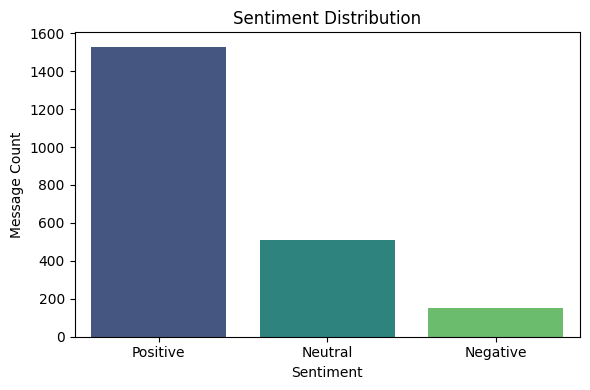

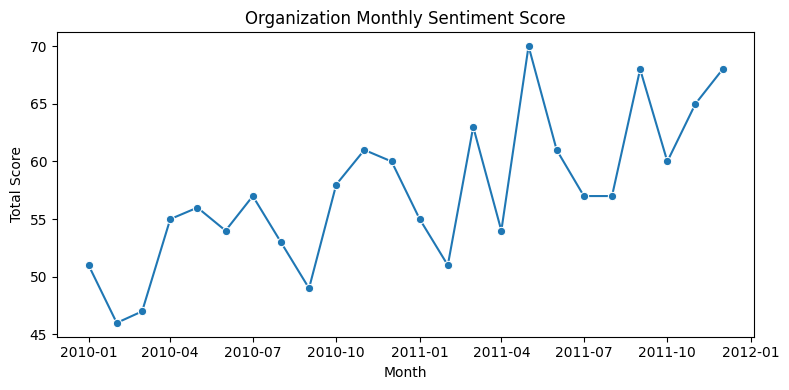


Latest Month: 2011-12-01 00:00:00

Top Positive Employees:
            employee      month  score
71        Eric Bass 2011-12-01     12
191  Patti Thompson 2011-12-01     12
167   Lydia Delgado 2011-12-01     10

Top Negative Employees:
           employee      month  score
119  Johnny Palmer 2011-12-01      2
23   Bobette Riner 2011-12-01      3
95     John Arnold 2011-12-01      4


/tmp/ipython-input-101165081.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, x='employee', y='score', palette='Greens_r')


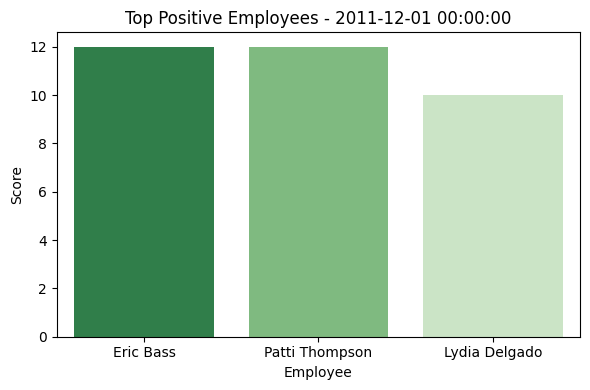

/tmp/ipython-input-101165081.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, x='employee', y='score', palette='Reds')


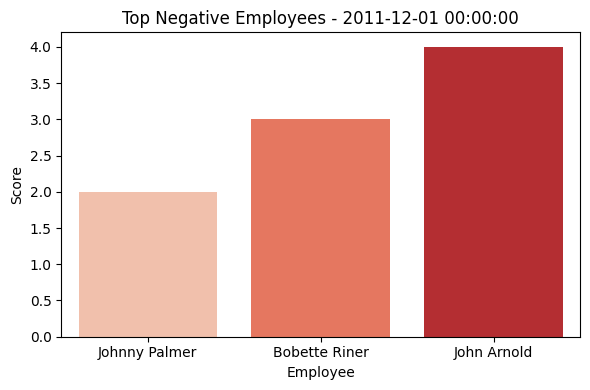


Flight Risk Employees: ['Bobette Riner' 'Don Baughman' 'Johnny Palmer' 'Sally Beck']

Predictive Model Metrics:
RMSE: 1.1633350351529511e-14
R²: 1.0

Model Coefficients:
          feature          coef
0  message_count  1.004443e-16
1     avg_length -1.110223e-16
2      pos_count  1.000000e+00
3      neg_count -1.000000e+00
4  neutral_count  2.029626e-16


/tmp/ipython-input-101165081.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='feature', y='coef', palette='coolwarm')


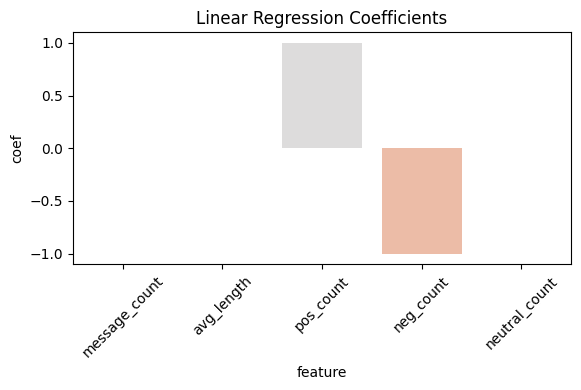

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

monthly_scores = pd.read_csv("monthly_scores.csv")
labeled_messages = pd.read_csv("labeled_messages.csv")
employee_month_features = pd.read_csv("employee_month_features.csv")

print("Monthly Scores Shape:", monthly_scores.shape)
print("Labeled Messages Shape:", labeled_messages.shape)
print("Employee Month Features Shape:", employee_month_features.shape)

print("\nMonthly Scores Head:\n", monthly_scores.head())
print("\nLabeled Messages Head:\n", labeled_messages.head())
print("\nEmployee Month Features Head:\n", employee_month_features.head())

sentiment_counts = labeled_messages['sentiment'].value_counts()
print("\nSentiment Counts:\n", sentiment_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Distribution")
plt.ylabel("Message Count")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("chart_sentiment_distribution.png")
plt.show()

monthly_scores['month'] = pd.to_datetime(monthly_scores['month'])
org_monthly = monthly_scores.groupby('month')['score'].sum().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(data=org_monthly, x='month', y='score', marker='o')
plt.title("Organization Monthly Sentiment Score")
plt.ylabel("Total Score")
plt.xlabel("Month")
plt.tight_layout()
plt.savefig("chart_org_monthly_score.png")
plt.show()

latest_month = monthly_scores['month'].max()
latest_df = monthly_scores[monthly_scores['month'] == latest_month]

top_positive = latest_df.sort_values(['score','employee'], ascending=[False, True]).head(3)
top_negative = latest_df.sort_values(['score','employee'], ascending=[True, True]).head(3)

print("\nLatest Month:", latest_month)
print("\nTop Positive Employees:\n", top_positive)
print("\nTop Negative Employees:\n", top_negative)


plt.figure(figsize=(6,4))
sns.barplot(data=top_positive, x='employee', y='score', palette='Greens_r')
plt.title(f"Top Positive Employees - {latest_month}")
plt.ylabel("Score")
plt.xlabel("Employee")
plt.tight_layout()
plt.savefig("chart_top_positive_latest_month.png")
plt.show()


plt.figure(figsize=(6,4))
sns.barplot(data=top_negative, x='employee', y='score', palette='Reds')
plt.title(f"Top Negative Employees - {latest_month}")
plt.ylabel("Score")
plt.xlabel("Employee")
plt.tight_layout()
plt.savefig("chart_top_negative_latest_month.png")
plt.show()


df_sorted = labeled_messages.sort_values(['employee', 'date'])
df_sorted['date'] = pd.to_datetime(df_sorted['date'])
df_sorted['is_negative'] = (df_sorted['sentiment'] == 'Negative').astype(int)

rolling_neg = df_sorted.groupby('employee').rolling('30D', on='date')['is_negative'].sum().reset_index()
flight_risk = rolling_neg[rolling_neg['is_negative'] >= 4]['employee'].unique()

print("\nFlight Risk Employees:", flight_risk)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = employee_month_features[['message_count','avg_length','pos_count','neg_count','neutral_count']]
y = employee_month_features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nPredictive Model Metrics:")
print("RMSE:", rmse)
print("R²:", r2)

coef_df = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})
print("\nModel Coefficients:\n", coef_df)

plt.figure(figsize=(6,4))
sns.barplot(data=coef_df, x='feature', y='coef', palette='coolwarm')
plt.title("Linear Regression Coefficients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("chart_lr_coefficients.png")
plt.show()


# 8. Conclusion

- Neutral dominates communication, but negative signals are still significant.  
- Monthly scores help identify both top performers and struggling employees.  
- Flight risk detection gives actionable insights for HR.  
- Predictive model shows that **positive/negative counts** are strong sentiment drivers.  


